---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


## Datasets

En la práctica de la clase de hoy usaremos un **conjunto de propiedades** que tienen a la venta la inmobiliaria Properati: https://www.properati.com.ar/. Lo interesante es que a los datos clásicos de la propiedad (valor, superficie, barrio, tipo de propiedad), le agrega la posición geoespacial mediante su latitud y longitud.

Por otra parte, vamos a considerar a las **estaciones de subte**, donde tambien figuran el nombre y la línea a la que pertenece, y además, obviamente, sus datos geoposicionales.

## Ejercicio

Comenzamos leyendo los dos datasets en un *dataframe*, y lo transformamos en un *GeoDataFrame*. Es el tipo de datos que requiere GeoPandas para realizar operaciones con datos geoespaciales.

Luego vamos a *calcular la distancia* de cada propiedad al obelisco de Buenos Aires, y se registrará en una nueva columna. Haremos un cálculo para ver si existe alguna relacion entre esta distancia y el precio de la propiedad.

Finalmente *trazaremos una línea geométrica* con todas las estaciones de subte de una línea, y la graficaremos sobre la ciudad.

Alla vamos!

---

Importamos las bibliotecas que vamos a necesitar:

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import shapely # genera las figuras geometricas
import descartes # relaciona shapely con matplotlib
import pyproj # proyecciones. Transformar coordenadas

### Parte 1 - Archivo de propiedades

Vamos a leer los datos del archivo /M1/CLASE_07/Data/properati_caba.csv en un `DataFrame` de pandas con el método `read_csv`. Lo llamaremos df_prop. 

*Nota:* los datos vienen separados por tabs. Se debe usar el parámetro <code>sep='\t'</code>

Ayuda:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [2]:
data_location = "../Data/properati_caba.csv"

df_prop = pd.read_csv(data_location, sep='\t', encoding="latin1")

- 1.a. Tomamos una muestra de 5 elementos

In [3]:
# 1.a
df_prop.sample(5)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
10638,house,Caballito,Argentina,Capital Federal,-34.624378,-58.428857,489000.0,USD,430.0
16600,PH,Velez Sarsfield,Argentina,Capital Federal,-34.635430,-58.488746,110000.0,USD,66.0
14221,apartment,San Telmo,Argentina,Capital Federal,-34.625135,-58.378901,78100.0,USD,43.0
2024,apartment,Recoleta,Argentina,Capital Federal,-34.603684,-58.381559,280000.0,USD,105.0
5359,house,Belgrano,Argentina,Capital Federal,-34.569249,-58.452457,850000.0,USD,330.0


- 1.b. Cuántas propiedades son? Cuántas columnas tiene?

In [4]:
# 1.b
df_prop.shape

(17223, 9)

- 1.c. Cuáles son las columnas? De qué tipo de datos son?

In [5]:
# 1.c
df_prop.dtypes

property_type           object
place_name              object
country_name            object
state_name              object
lat                    float64
lon                    float64
price                  float64
currency                object
surface_total_in_m2    float64
dtype: object

In [6]:
# 1.c. Otra
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17223 entries, 0 to 17222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        17223 non-null  object 
 1   place_name           17223 non-null  object 
 2   country_name         17223 non-null  object 
 3   state_name           17223 non-null  object 
 4   lat                  17223 non-null  float64
 5   lon                  17223 non-null  float64
 6   price                17223 non-null  float64
 7   currency             17223 non-null  object 
 8   surface_total_in_m2  17223 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


- 1.d. ¿Cuántas propiedades tenemos por barrio? El barrio figura en la columna *place_name*.

Ayuda:

    - Libro McKinney - Python for Data Analysis 2ed.pdf - capitulo 10 Data Aggregation and Group Operations

    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html?highlight=value_counts#pandas.Series.value_counts

In [7]:
# 1.d.
barrios = df_prop["place_name"]
barrios.value_counts()

place_name
Palermo            1502
Belgrano           1496
Caballito          1389
Recoleta           1001
Flores              893
                   ... 
Parque Chas          15
Palermo Viejo        10
Villa Soldati         7
Villa Riachuelo       3
Catalinas             1
Name: count, Length: 62, dtype: int64

In [8]:
# 1.d. Otra forma
grouped = df_prop['price'].groupby(df_prop['place_name'])
grouped.count()

place_name
Abasto               59
AgronomÃ­a           25
Almagro             755
Balvanera           426
Barracas            309
                   ... 
Villa Riachuelo       3
Villa Santa Rita     26
Villa Soldati         7
Villa Urquiza       774
Villa del Parque    215
Name: price, Length: 62, dtype: int64

In [9]:
# 1.d. Otra forma parecida
df_prop.groupby(['place_name'])[['price']].count()

,price
place_name,
Abasto,59
AgronomÃ­a,25
Almagro,755
Balvanera,426
Barracas,309
...,...
Villa Riachuelo,3
Villa Santa Rita,26
Villa Soldati,7


- 1.e. Las columnas *lat* y *lon* identifican la *latitud* y la *longitud* de la posición geoespacial de las propiedades. Pero necesitamos que la posición se exprese mediante la forma geométrica Punto, para poder trabajarlo desde GeoPandas.

Es decir que debemos transformar el DataFrame en un GeoDataFrame. Lo llamaremos *geo_prop*.

Pero para generar un GeoDataFrame, necesitamos agregar a las columnas del DataFrame una nueva columna que contenga una forma geométrica. Es este caso, un *punto*, el cual se genera a partir de la *latitud* y la *longitud*. 

Es recomendable que la nueva columna se llame *geometry*.

Con el método `gpd.points_from_xy` lo realizamos.

*Observar* que para definir el tipo *punto*, primero se ingresa la **longitud** y luego la **latitud**.

Ayuda:
https://geopandas.org/reference/geopandas.points_from_xy.html

In [10]:
# 1.e
geometria = gpd.points_from_xy(df_prop.lon, df_prop.lat)
geo_prop = gpd.GeoDataFrame(df_prop ,geometry=geometria)

In [11]:
# 1.e. Otra forma
geo_prop1 = gpd.GeoDataFrame(df_prop
                           ,geometry=gpd.points_from_xy(df_prop.lon, df_prop.lat))

Verificamos la nueva columna mirando las primeras filas

In [12]:
# 1.e
geo_prop.loc[:4, ['geometry', 'lat', 'lon','property_type','place_name']]

,geometry,lat,lon,property_type,place_name
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos


---

### Parte 2 - Archivo de estaciones de subte

Vamos a leer los datos del archivo /M1/CLASE_07/Data/estaciones-de-subte.csv en un `DataFrame` de pandas con el método `read_csv`. Lo llamaremos df_subte.

*Nota:* los datos vienen separados por comas. Se debe usar el parámetro <code>sep=','</code>

In [13]:
data_location = "../Data/estaciones-de-subte.csv"

df_subte = pd.read_csv(data_location, sep=',')

- 2.a. Consultamos los primeros 10 registros

In [53]:
#2.a.
df_subte.head(10)

,long,lat,id,estacion,linea
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H
5,-58.380574,-34.604245,6.0,9 DE JULIO,D
6,-58.397924,-34.599757,7.0,FACULTAD DE MEDICINA,D
7,-58.385142,-34.601587,8.0,TRIBUNALES - TEATRO COLÓN,D
8,-58.407161,-34.591628,9.0,AGÜERO,D
9,-58.415955,-34.585156,10.0,R.SCALABRINI ORTIZ,D


- 2.b. Cuántas estaciones son? Cuántas columnas tiene?

In [15]:
# 2.b.
print("estaciones: " + str(df_subte.shape[0]))
print("columnas: " + str(df_subte.shape[1]))

estaciones: 90
columnas: 5


- 2.c. Cuáles son las columnas? De qué tipo de datos son?

In [16]:
# 2.c.
df_subte.dtypes

long        float64
lat         float64
id          float64
estacion     object
linea        object
dtype: object

- 2.d. ¿Cuantas estaciones tenemos por línea?

Ayuda: es similar al punto 1.d

In [17]:
# 2.d.
lineas = df_subte["linea"]
lineas.value_counts()

linea
A    18
E    18
B    17
D    16
H    12
C     9
Name: count, dtype: int64

In [18]:
# 2.d. Otra forma
grouped = df_subte['id'].groupby(df_subte['linea'])
grouped.count()

linea
A    18
B    17
C     9
D    16
E    18
H    12
Name: id, dtype: int64

In [19]:
# 2.d. Otra forma parecida
df_subte.groupby(['linea'])[['id']].count()

,id
linea,
A,18
B,17
C,9
D,16
E,18
H,12


- 2.e. Las columnas *lat* y *long* identifican la *latitud* y la *longitud* de la posición geoespacial de las propiedades. Pero necesitamos que la posición se exprese mediante la forma geométrica Punto, para poder trabajarlo desde GeoPandas.

Ayuda: es similar al punto 1.e

In [20]:
# 2.e.
geo_subte = gpd.GeoDataFrame(df_subte
                           ,geometry=gpd.points_from_xy(df_subte.long, df_subte.lat))

Verificamos la nueva columna mirando las primeras filas

In [21]:
geo_subte.head(5)

,long,lat,id,estacion,linea,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)


---

### Parte 3 - Cálculo de la distancia

Vamos a calcular la **distancia de cada propiedad al obelisco de Buenos Aires**, y la registramos en una nueva columna.

Primero necesitamos representar el lugar geográfico del Obelisco de Buenos Aires. Lo hacemos mediante la forma geométrica *Punto*, y las cooordenadas del lugar. 

In [22]:
from shapely.geometry import Point

punto_obelisco_p = Point(-58.381555,-34.605425)

In [23]:
type(punto_obelisco_p)

shapely.geometry.point.Point

Pero el método que calcula la distancia entre dos puntos, <code>geopy.distance.geodesic</code>, necesita representar el lugar geográfico del Obelisco de Buenos Aires mediante una *tupla*.

In [24]:
punto_obelisco = (-58.381555,-34.605425)

In [25]:
type(punto_obelisco)

tuple

Ahora podemos agregar la nueva columna con la distancia entre el punto del obelisco y el punto de cada propiedad (en metros). La llamaremos *distancia_obelisco*. 

Se debe generar **una iteración** sobre el indice de geo_prop:

Ayuda:
<code>
for i in geo_prop.index:
    geo_prop.loc[i, 'distancia_obelisco'] = calculo distancia entre obelisco y cada propiedad.</code>
    
El cálculo se realiza con el método <code>geopy.distance.geodesic</code>, el cual se explica en la notebook 3_geopandas_operaciones.

Ademas con la sentencia <code>geo_prop.loc[i,'geometry'].x</code> obtenemos la coordenada longitud de la distancia.

Debe terminar con <code>.meters</code> para indicar la distancia en metros

Ver https://geopy.readthedocs.io/en/stable/#module-geopy.distance

In [26]:
# 3.a
import geopy.distance

for i in geo_prop.index:
    geo_prop.loc[i, 'distancia_obelisco'] = geopy.distance.geodesic(punto_obelisco,
                  (geo_prop.loc[i,'geometry'].x
                  ,geo_prop.loc[i,'geometry'].y)).meters

Verificamos la nueva columna mirando las primeras filas

In [27]:
geo_prop.loc[:4, ['distancia_obelisco','geometry', 'lat', 'lon','property_type','place_name']]

,distancia_obelisco,geometry,lat,lon,property_type,place_name
0,14555.078219,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,15988.570648,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,7381.316759,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,7381.316759,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,13651.907067,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos


Vamos a calcular una relación entre la distancia al obelisco y los precios de cada propiedad. 

Calculemos el promedio por barrio de la distancia y de los precios.Y luego hacemos un ranking de los promedios, y vemos si los primeros 10 rankeados de cada promedio son de los mismos barrios.

Para todos los calculos necesitamos usar el método **groupby**.

Primero se debe crear un nuevo GeoDataFrame con tantas filas como barrios tenemos.

In [28]:
geo_prop_group = geo_prop.groupby(['place_name']).count()

In [29]:
type(geo_prop_group)

pandas.core.frame.DataFrame

In [30]:
geo_prop_group

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco
place_name,,,,,,,,,,
Abasto,59,59,59,59,59,59,59,59,59,59
AgronomÃ­a,25,25,25,25,25,25,25,25,25,25
Almagro,755,755,755,755,755,755,755,755,755,755
Balvanera,426,426,426,426,426,426,426,426,426,426
Barracas,309,309,309,309,309,309,309,309,309,309
...,...,...,...,...,...,...,...,...,...,...
Villa Riachuelo,3,3,3,3,3,3,3,3,3,3
Villa Santa Rita,26,26,26,26,26,26,26,26,26,26
Villa Soldati,7,7,7,7,7,7,7,7,7,7


Luego debemos agregar dos columnas con los promedios (distancia y precio) por barrio.

Ayuda:
<code>
geo_prop_group['nueva columna'] = geo_prop.groupby(['xxxxxxx'])[["yyyy"]].mean()
</code>

In [31]:
# 3.b. Promedio precios por barrio
geo_prop_group['precio']  =  geo_prop.groupby(['place_name'])[['price']].mean()

In [32]:
# 3.b.Promedio distancia por barrio
geo_prop_group['distancia'] =  geo_prop.groupby(['place_name'])[['distancia_obelisco']].mean()

Y finalmente, agregar otras dos columnas con el ranking según el promedio (distancia y precio) por barrio.

Ayuda:
<code>
geo_prop_group["nueva columna rank"] = geo_prop_group.xxxxxxxx.rank(ascending=True)
</code>

In [33]:
# 3.b.Ranking distancia por barrio
geo_prop_group["rank_distancia"] = geo_prop_group.distancia.rank(ascending=True)

In [34]:
# 3.b.Ranking precio por barrio
geo_prop_group["rank_precio"] = geo_prop_group.precio.rank(ascending=False)

Verificamos las nuevas columnas

In [35]:
geo_prop_group.loc[:, ['precio','distancia','rank_distancia','rank_precio']]

,precio,distancia,rank_distancia,rank_precio
place_name,,,,
Abasto,1.792157e+05,3366.178150,19.0,49.0
AgronomÃ­a,1.597952e+05,11496.658313,50.0,56.0
Almagro,2.383719e+05,4487.683052,23.0,24.0
Balvanera,1.667908e+05,2428.895604,15.0,53.0
Barracas,1.924282e+05,2152.119311,11.0,43.0
...,...,...,...,...
Villa Riachuelo,1.833333e+05,11034.007945,46.0,48.0
Villa Santa Rita,2.113846e+05,10786.585585,44.0,34.0
Villa Soldati,1.310730e+06,7454.006046,34.0,1.0


Finalmente, observar si los primeros 10 rankeados de cada promedio son de los mismos barrios.

Primero hacerlo sobre el ranking de distancia, y luego sobre el ranking de precios.

Ayuda: https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.sort_values.html

In [36]:
# 10 primeros rankeados por distancia
geo_prop_group.sort_values(by="rank_distancia").head(10)

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco,precio,distancia,rank_distancia,rank_precio
place_name,,,,,,,,,,,,,,
Catalinas,1,1,1,1,1,1,1,1,1,1,550000.000000,634.212781,1.0,6.0
Centro / Microcentro,190,190,190,190,190,190,190,190,190,190,237368.142105,680.202508,2.0,25.0
San NicolÃ¡s,118,118,118,118,118,118,118,118,118,118,190561.237288,693.926823,3.0,45.0
Tribunales,65,65,65,65,65,65,65,65,65,65,198811.830769,836.603422,4.0,37.0
Retiro,141,141,141,141,141,141,141,141,141,141,412255.000000,839.671966,5.0,11.0
Monserrat,265,265,265,265,265,265,265,265,265,265,199876.535849,888.232530,6.0,35.0
ConstituciÃ³n,154,154,154,154,154,154,154,154,154,154,164743.538961,1236.226130,7.0,54.0
San Telmo,573,573,573,573,573,573,573,573,573,573,506590.057592,1280.499050,8.0,7.0
Congreso,174,174,174,174,174,174,174,174,174,174,153215.413793,1382.937608,9.0,59.0


In [37]:
# 10 primeros rankeados por precio
geo_prop_group.sort_values(by="rank_precio").head(10)

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco,precio,distancia,rank_distancia,rank_precio
place_name,,,,,,,,,,,,,,
Villa Soldati,7,7,7,7,7,7,7,7,7,7,1.310730e+06,7454.006046,34.0,1.0
NuÃ±ez,384,384,384,384,384,384,384,384,384,384,1.164123e+06,9772.556382,41.0,2.0
Palermo Chico,146,146,146,146,146,146,146,146,146,146,1.100355e+06,3689.581743,20.0,3.0
Puerto Madero,364,364,364,364,364,364,364,364,364,364,9.774262e+05,2234.361297,12.0,4.0
Belgrano,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,5.778869e+05,8403.113119,37.0,5.0
Catalinas,1,1,1,1,1,1,1,1,1,1,5.500000e+05,634.212781,1.0,6.0
San Telmo,573,573,573,573,573,573,573,573,573,573,5.065901e+05,1280.499050,8.0,7.0
Recoleta,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,5.062143e+05,1779.484055,10.0,8.0
Boedo,278,278,278,278,278,278,278,278,278,278,4.437263e+05,4146.008502,22.0,9.0


### Parte 4 - Línea que una a las estaciones de subte

Vamos a hacer una línea geométrica con las estaciones de subte de la línea H y graficarla sobre la ciudad.

<div>
    <div class = "mapa">
        <img src='img/M1_Clase_07_1_desafio.jpg' alt="Elementos geométricos" width=80% height=90%>
    </div>
</div>

In [38]:
geo_subte.head(4)

,long,lat,id,estacion,linea,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)


Primero seleccionemos solo las estaciones de la linea H, y guardamos la selección en la variable geo_subte_h.

In [39]:
geo_subte_h = geo_subte.loc[geo_subte.linea =='H', :]

In [40]:
geo_subte_h

,long,lat,id,estacion,linea,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)
76,-58.405450,-34.604490,77.0,CORRIENTES,H,POINT (-58.40545 -34.60449)
77,-58.405795,-34.638406,78.0,PARQUE PATRICIOS,H,POINT (-58.40579 -34.63841)
78,-58.412385,-34.641269,79.0,HOSPITALES,H,POINT (-58.41239 -34.64127)
83,-58.403721,-34.598455,84.0,CÓRDOBA,H,POINT (-58.40372 -34.59846)
84,-58.397216,-34.587462,85.0,LAS HERAS,H,POINT (-58.39722 -34.58746)


Como muestra el dibujo, la línea corre de Norte a Sur (o Sur a Norte). Como las estaciones deben estar alineadas para que salga bien la línea, podemos usar la columna lat para ordenarlas; lat es la latitud de cada estación.

Ayuda: considerar sort_values con by
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html

In [41]:
geo_subte_h = geo_subte_h.sort_values(by='lat')

In [42]:
geo_subte_h

,long,lat,id,estacion,linea,geometry
78,-58.412385,-34.641269,79.0,HOSPITALES,H,POINT (-58.41239 -34.64127)
77,-58.405795,-34.638406,78.0,PARQUE PATRICIOS,H,POINT (-58.40579 -34.63841)
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)
76,-58.405450,-34.604490,77.0,CORRIENTES,H,POINT (-58.40545 -34.60449)
83,-58.403721,-34.598455,84.0,CÓRDOBA,H,POINT (-58.40372 -34.59846)
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H,POINT (-58.40238 -34.59453)


Para simplificar la codificación, solo nos quedaremos con los datos geográficos de cada estación.

Generamos una *GeoSeries* con la columna geometry de geo_subte_h. Y la llamamos geo_subte_h_geometry.

In [43]:
geo_subte_h_geometry = geo_subte_h["geometry"]

In [44]:
type(geo_subte_h_geometry)

geopandas.geoseries.GeoSeries

Ahora creamos las líneas que unen a las estaciones de subte. 

Cada línea se forma con **dos puntos**. Por lo tanto, tenemos que tomar el primer y segundo punto de la Geoserie, y aplicarles el método <code>LineString</code>. Luego seguimos con el segundo y el tercero, y así siguiendo.

*Primero creamos una lista donde guardaremos cada linea.* La llamamos linea_h. Debe tener una longitud igual a la cantidad de estaciones menos 1, es decir longitud 11.

In [45]:
longitud_linea = len(geo_subte_h_geometry)-1
linea_h = list(range(longitud_linea))

In [46]:
len(linea_h)

11

Ahora podemos crear las líneas y guardarlas en la lista.

Se debe generar **una iteración** para recorrer la GeoSerie *geo_subte_h_geometry*.

Ayuda:
<code>
for i in range(longitud_linea): 
    linea_h[i] = creo la linea entre el elemento i y el elemento i+1
</code> 
    
El cálculo se realiza con el método <code>LineString</code> de la libreria shapely, el cual se explica en la notebook 3_geopandas_operaciones.

In [47]:
from shapely.geometry import LineString

for i in range(longitud_linea): 
    linea_h[i] = LineString([geo_subte_h_geometry.iloc[i], geo_subte_h_geometry.iloc[i+1]])

---

Ahora vamos a graficar las líneas sobre un mapa con los barrios de Buenos Aires.

Vamos a leer los datos del archivo /M1/CLASE_07/Data/barrios.csv en un `DataFrame` de pandas con el método `read_csv`. Lo llamaremos df_barrios.

In [48]:
df_barrios = pd.read_csv("../Data/barrios.csv", encoding='latin1')

---

Y luego generamos un GeoDataFrame de los barrios a partir del Dataframe. En este caso, la columna WKT ya contiene una forma geométrica **polígono** que representa el contorno de cada barrio. Pero en un formato WKT, que no permite generar un GeoDataFrame. Por lo tanto, lo tenemos que convertir a un formato *geometry*.

In [49]:
import shapely.wkt

df_barrios["WKT"] = df_barrios["WKT"].apply(shapely.wkt.loads) 
geo_barrios = gpd.GeoDataFrame(df_barrios, geometry='WKT')

Por otra parte, necesitamos para graficar las líneas generar una GeoSerie donde cada elemento se compone de dos puntos y la línea entre ellos.

In [50]:
linea_h_geo = list(range(longitud_linea))

for i in range(longitud_linea): 
    linea_h_geo[i] = gpd.GeoSeries([geo_subte_h_geometry.iloc[i], geo_subte_h_geometry.iloc[i+1], linea_h[i]])

Con el método plot generamos el gráfico:

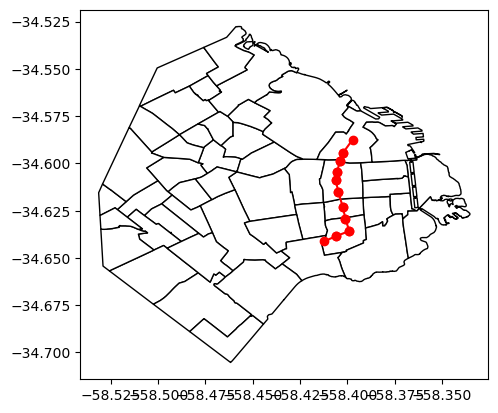

In [51]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
geo_barrios.plot(ax=ax, color='white', edgecolor='black')

for i in range(len(geo_subte_h_geometry)-2): 
    linea_h_geo[i].plot(ax=ax, color='red')

plt.show();

In [56]:
import numpy as np
a = np.arange(15)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [59]:
mask_a = a>=5 
mask_b = a<=10 
mask = np.logical_or(mask_a, mask_b)
a[mask]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [67]:
data = pd.Series([0.25, 0.5, 0.75, 1.0], index=['a', 'b', 'c', 'd'])
mask = [x in ['a', 'd'] for x in data.index]
mask

[True, False, False, True]